https://docs.google.com/document/d/15GMxvJYAUO-b96c18QmfcF278IVVBBtCFk8nayDp9oY/edit

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import os
import scipy as sp
from scipy import stats

from tools.plt import color2d #from the 'srcole/tools' repo
from matplotlib import cm
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 100

### Load dataframes

In [2]:
# Load cities info
df_cities = pd.read_csv('/gh/data2/yelp/city_pop.csv', index_col=0)
df_cities.head()

,city,state,population,total_food,latitude,longitude,total_scraped
0,New York,New York,8537673,54191,40.705445,-73.994293,1000
1,Los Angeles,California,3976322,41685,34.061590,-118.321381,1000
2,Chicago,Illinois,2704958,19315,41.905159,-87.677765,1000
3,Houston,Texas,2303482,15197,29.784854,-95.359955,1000
4,Phoenix,Arizona,1615017,11034,33.465086,-112.070160,1000


In [3]:
# Load restaurants
df_restaurants = pd.read_csv('/gh/data2/yelp/food_by_city/df_restaurants.csv', index_col=0)
df_restaurants.head()

,id,name,city,state,rating,review_count,cost,latitude,longitude,has_delivery,has_pickup,url
0,poquito-picante-brooklyn-2,Poquito Picante,New York,New York,4.5,40,2,40.685742,-73.981262,True,True,https://www.yelp.com/biz/poquito-picante-brook...
1,nourish-brooklyn-4,Nourish,New York,New York,4.0,65,2,40.677960,-73.968550,True,True,https://www.yelp.com/biz/nourish-brooklyn-4?ad...
2,taste-of-heaven-brooklyn,Taste of Heaven,New York,New York,5.0,19,2,40.717150,-73.940540,False,True,https://www.yelp.com/biz/taste-of-heaven-brook...
3,milk-and-cream-cereal-bar-new-york,Milk & Cream Cereal Bar,New York,New York,4.5,307,2,40.719580,-73.996540,False,False,https://www.yelp.com/biz/milk-and-cream-cereal...
4,the-bao-shoppe-new-york-2,The Bao Shoppe,New York,New York,4.0,99,1,40.714345,-73.990518,False,False,https://www.yelp.com/biz/the-bao-shoppe-new-yo...


In [4]:
# Load categories by restaurant
df_categories = pd.read_csv('/gh/data2/yelp/food_by_city/df_categories.csv', index_col=0)
df_categories.head()

,acaibowls,accessories,active,acupuncture,adultedu,advertising,aerialfitness,afghani,african,airport_shuttles,...,wine_bars,wineries,winetasteclasses,winetastingroom,winetours,womenscloth,wraps,yelpevents,yoga,zoos
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
# These are used for the 'category' input to the search function
df_categories_info = pd.read_json('/gh/data2/yelp/categories.json')
df_categories_info.head()

,alias,country_blacklist,country_whitelist,parents,title
0,3dprinting,NaN,NaN,[localservices],3D Printing
1,abruzzese,NaN,[IT],[italian],Abruzzese
2,absinthebars,NaN,[CZ],[bars],Absinthe Bars
3,acaibowls,"[AR, PL, TR, MX, CL, IT]",NaN,[food],Acai Bowls
4,accessories,NaN,NaN,[fashion],Accessories


In [6]:
from bokeh.io import output_notebook
from bokeh.layouts import row, widgetbox
from bokeh.models import CustomJS, Slider, Legend, HoverTool
from bokeh.plotting import figure, output_file, show, ColumnDataSource

output_notebook()

Loading BokehJS ...

# Cuisines by city

In [ ]:
# New dataframe: For each cuisine, compute the average rating, average price, and # restaurants
all_cuisines = df_categories.keys()
cuisine_dict = {'cuisine': [],
                'avg_rating': [],
                'avg_cost': [],
                'N': []}
for k in all_cuisines:
    df_temp = df_restaurants[df_categories[k]==1]
    cuisine_dict['cuisine'].append(k)
    cuisine_dict['avg_rating'].append(df_temp['rating'].mean())
    cuisine_dict['avg_cost'].append(df_temp['cost'].mean())
    cuisine_dict['N'].append(len(df_temp))
df_cuisine = pd.DataFrame.from_dict(cuisine_dict)

# Determine cuisines of interest
# Only look at cuisines with at least 2000 restaurants
min_N = 1000
category_counts = df_categories.sum()
categories_keep = category_counts[category_counts > min_N]
cuisines_rmv = ['bars', 'beer_and_wine', 'beerbar', 'breweries', 'butcher', 'cafes', 'catering',
                'chickenshop', 'cocktailbars', 'convenience', 'cosmetics', 'customcakes',
                'deptstores', 'divebars', 'drugstores', 'eventplanning', 'farmersmarket', 'fooddeliveryservices',
                'foodstands', 'gastropubs', 'gourmet', 'grocery', 'healthmarkets', 'importedfood', 'intlgrocery',
                'karaoke', 'lounges', 'markets', 'meats', 'musicvenues', 'personalchefs', 'pubs',
                'restaurants', 'salvadoran', 'seafoodmarkets', 'servicestations', 'sportsbars', 'streetvendors',
                'tapasmallplates', 'venues', 'wine_bars', 'wineries']
categories_keep.drop(cuisines_rmv, inplace=True)
categories_keep = categories_keep.keys()

In [27]:
# Set up dataframe for restaurants with categories of interest
restaurant_have_category = df_categories[categories_keep].sum(axis=1).to_dict()
df_restaurants_keep_idx = [k for k in restaurant_have_category.keys() if restaurant_have_category[k]]
df_restaurants_temp = df_restaurants.loc[df_restaurants_keep_idx].reset_index(drop=True)
df_categories_temp = df_categories[categories_keep].loc[df_restaurants_keep_idx].reset_index(drop=True)
df_restaurants_temp = df_restaurants_temp.merge(df_categories_temp, left_index=True, right_index=True)

In [49]:
# Compute fraction of each cuisine by city
df_city_cuisines = df_restaurants_temp.groupby('city').mean()
df_state_cuisines = df_restaurants_temp.groupby('state').mean()

# Explore features by city
* rating, review_count, cost, has_delivery, has_pickup
* each cuisine

In [42]:
df_city_cuisines.head(5)

,rating,review_count,cost,latitude,longitude,has_delivery,has_pickup,asianfusion,bagels,bakeries,bbq,breakfast_brunch,bubbletea,buffets,burgers,cajun,candy,caribbean,cheesesteaks,chicken_wings,chinese,chocolate,coffee,comfortfood,creperies,cuban,cupcakes,delis,desserts,diners,donuts,filipino,fishnchips,foodtrucks,french,gluten_free,greek,halal,hawaiian,hotdog,hotdogs,icecream,indpak,italian,japanese,juicebars,korean,latin,mediterranean,mexican,mideastern,newamerican,noodles,pakistani,peruvian,pizza,poke,ramen,salad,sandwiches,seafood,shavedice,soulfood,soup,southern,spanish,steak,sushi,tacos,taiwanese,tapas,tex-mex,thai,tradamerican,vegan,vegetarian,vietnamese,waffles
city,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Abilene,3.436709,21.718354,1.661392,32.427023,-99.737300,0.012658,0.028481,0.015823,0.000000,0.047468,0.056962,0.041139,0.003165,0.018987,0.107595,0.009494,0.012658,0.000000,0.000000,0.063291,0.037975,0.006329,0.063291,0.006329,0.000000,0.006329,0.006329,0.028481,0.022152,0.015823,0.025316,0.000000,0.000000,0.037975,0.000000,0.000000,0.003165,0.000000,0.000000,0.009494,0.212025,0.025316,0.000000,0.028481,0.012658,0.015823,0.000000,0.003165,0.000000,0.145570,0.000000,0.015823,0.000000,0.000000,0.000000,0.091772,0.000000,0.000000,0.034810,0.132911,0.031646,0.012658,0.003165,0.003165,0.015823,0.000000,0.031646,0.009494,0.003165,0.000000,0.000000,0.053797,0.006329,0.120253,0.000000,0.003165,0.000000,0.000000
Akron,3.723174,32.441781,1.755708,41.076724,-81.537897,0.028539,0.035388,0.014840,0.004566,0.028539,0.015982,0.075342,0.003425,0.004566,0.126712,0.004566,0.006849,0.000000,0.003425,0.051370,0.043379,0.000000,0.041096,0.005708,0.001142,0.000000,0.000000,0.031963,0.023973,0.025114,0.011416,0.000000,0.000000,0.013699,0.001142,0.012557,0.013699,0.000000,0.000000,0.010274,0.124429,0.028539,0.009132,0.059361,0.019406,0.010274,0.003425,0.005708,0.022831,0.079909,0.010274,0.095890,0.003425,0.000000,0.000000,0.143836,0.000000,0.001142,0.070776,0.172374,0.044521,0.000000,0.004566,0.022831,0.005708,0.000000,0.030822,0.021689,0.002283,0.000000,0.000000,0.009132,0.019406,0.152968,0.007991,0.003425,0.000000,0.003425
Alameda,3.957788,263.149822,1.569560,37.791706,-122.253565,0.099881,0.233056,0.036861,0.010702,0.041617,0.033294,0.098692,0.014269,0.004756,0.071344,0.008323,0.002378,0.008323,0.003567,0.011891,0.059453,0.001189,0.086801,0.007134,0.004756,0.002378,0.005945,0.035672,0.040428,0.008323,0.008323,0.013080,0.002378,0.076100,0.007134,0.007134,0.005945,0.005945,0.010702,0.014269,0.039239,0.021403,0.013080,0.029727,0.039239,0.020214,0.019025,0.011891,0.017836,0.145065,0.007134,0.055886,0.027348,0.003567,0.004756,0.061831,0.010702,0.009512,0.042806,0.135553,0.054697,0.001189,0.016647,0.021403,0.013080,0.002378,0.005945,0.028537,0.008323,0.003567,0.003567,0.002378,0.027348,0.053508,0.020214,0.016647,0.052319,0.005945
Albany,3.532189,35.735622,1.754506,41.086607,-81.267210,0.075536,0.105579,0.016309,0.007725,0.035193,0.022318,0.073820,0.006867,0.008584,0.092704,0.000858,0.003433,0.012017,0.003433,0.048069,0.058369,0.006867,0.076395,0.002575,0.000858,0.001717,0.004292,0.044635,0.020601,0.024893,0.021459,0.000858,0.005150,0.018884,0.004292,0.002575,0.007725,0.006867,0.001717,0.016309,0.115021,0.042060,0.014592,0.076395,0.035193,0.009442,0.004292,0.005150,0.013734,0.055794,0.002575,0.054936,0.004292,0.003433,0.000858,0.134764,0.000858,0.001717,0.045494,0.151073,0.035193,0.000858,0.004292,0.019742,0.009442,0.003433,0.021459,0.028326,0.000858,0.001717,0.002575,0.014592,0.017167,0.115880,0.006009,0.007725,0.005150,0.002575
Albuquerque,3.895857,68.294591,1.594937,35.110814,-106.609652,0.032221,0.071346,0.021864,0.002301,0.041427,0.026467,0.105869,0.003452,0.006904,0.108170,0.004603,0.004603,0.004603,0.000000,0.010357,0.048331,0.003452,0.066743,0.006904,0.005754,0.002301,0.005754,0.026467,0.026467,0.018412,0.002301,0.001151,0.000000,0.071346,0.014960,0.013809,0.011507,0.001151,0.003452,0.010357,0.090909

# Highest average rating
* Highest average rating are the most popular cities because yelp will return the top ones in each city

(-1, 60)

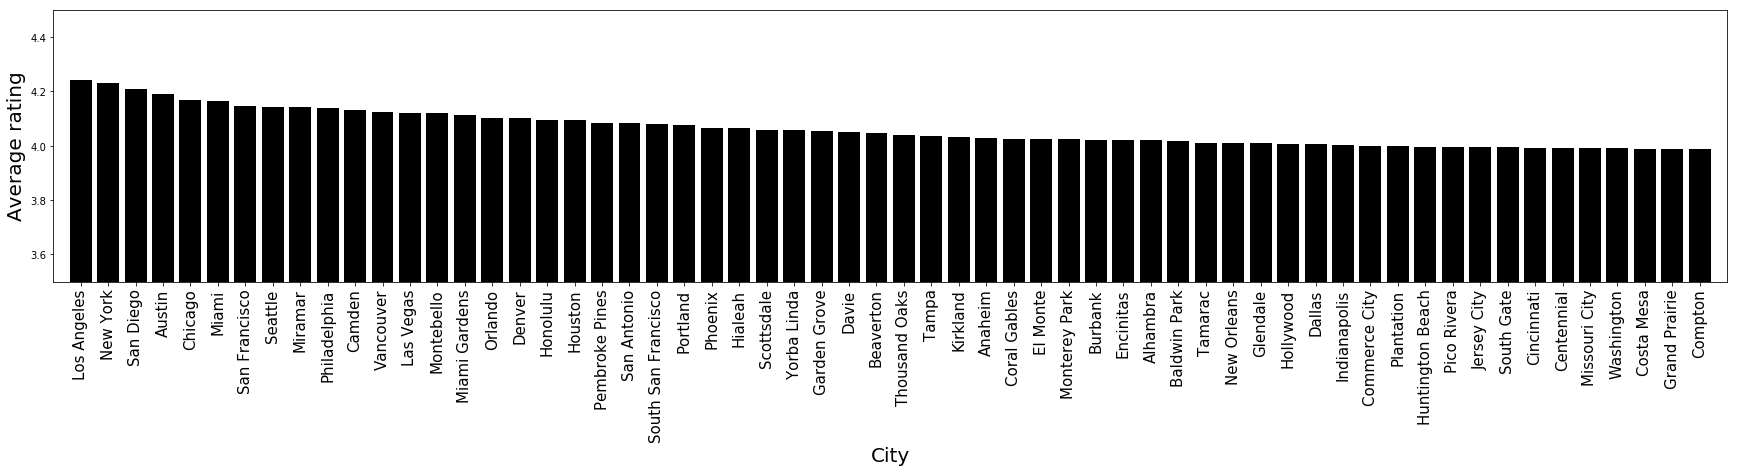

In [43]:
df_city_cuisines.sort_values('rating', ascending=False, inplace=True)

N=60
plt.figure(figsize=(30,5))
plt.bar(np.arange(N), df_city_cuisines['rating'].values[:N], color='k', ecolor='.5')
plt.xticks(np.arange(N), df_city_cuisines.index[:N])
plt.ylabel('Average rating', size=20)
plt.xlabel('City', size=20)
plt.xticks(size=15, rotation='vertical')
# plt.yticks([10**3, 10**4, 10**5], size=15)
plt.ylim((3.5, 4.5))
plt.xlim((-1, N))

# boba

(-1, 60)

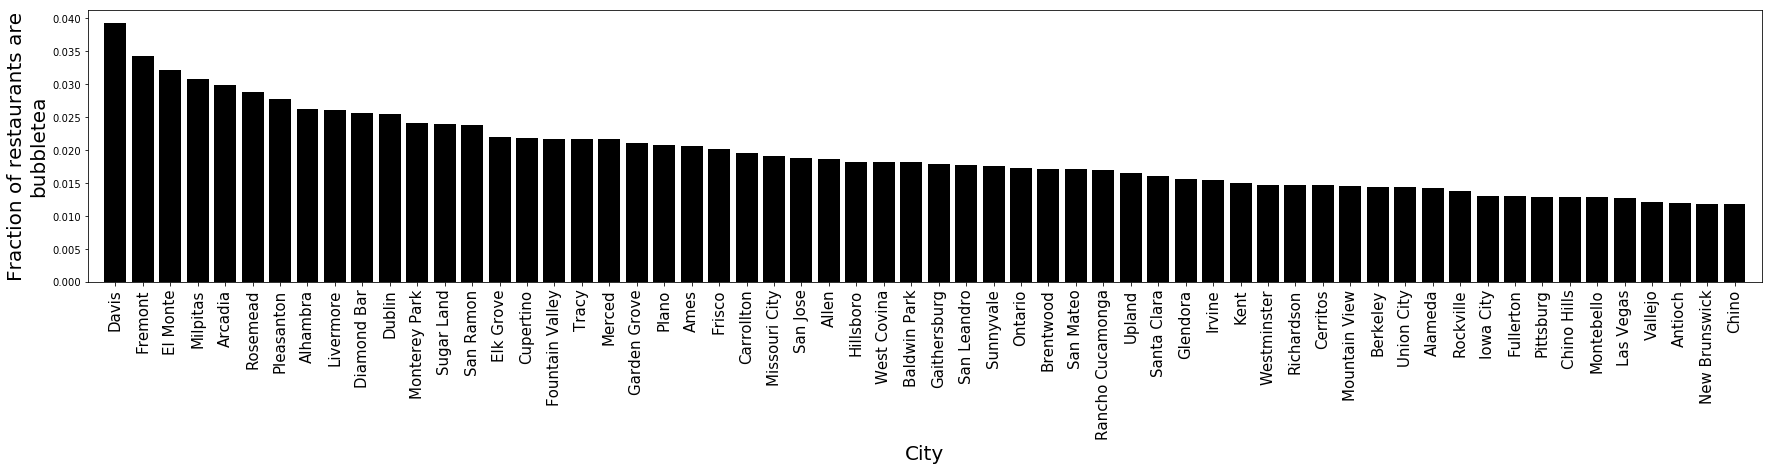

In [47]:
c = 'bubbletea'
df_city_cuisines.sort_values(c, ascending=False, inplace=True)

N=60
plt.figure(figsize=(30,5))
plt.bar(np.arange(N), df_city_cuisines[c].values[:N], color='k', ecolor='.5')
plt.xticks(np.arange(N), df_city_cuisines.index[:N])
plt.ylabel('Fraction of restaurants are\n'+c, size=20)
plt.xlabel('City', size=20)
plt.xticks(size=15, rotation='vertical')
plt.xlim((-1, N))

(-1, 50)

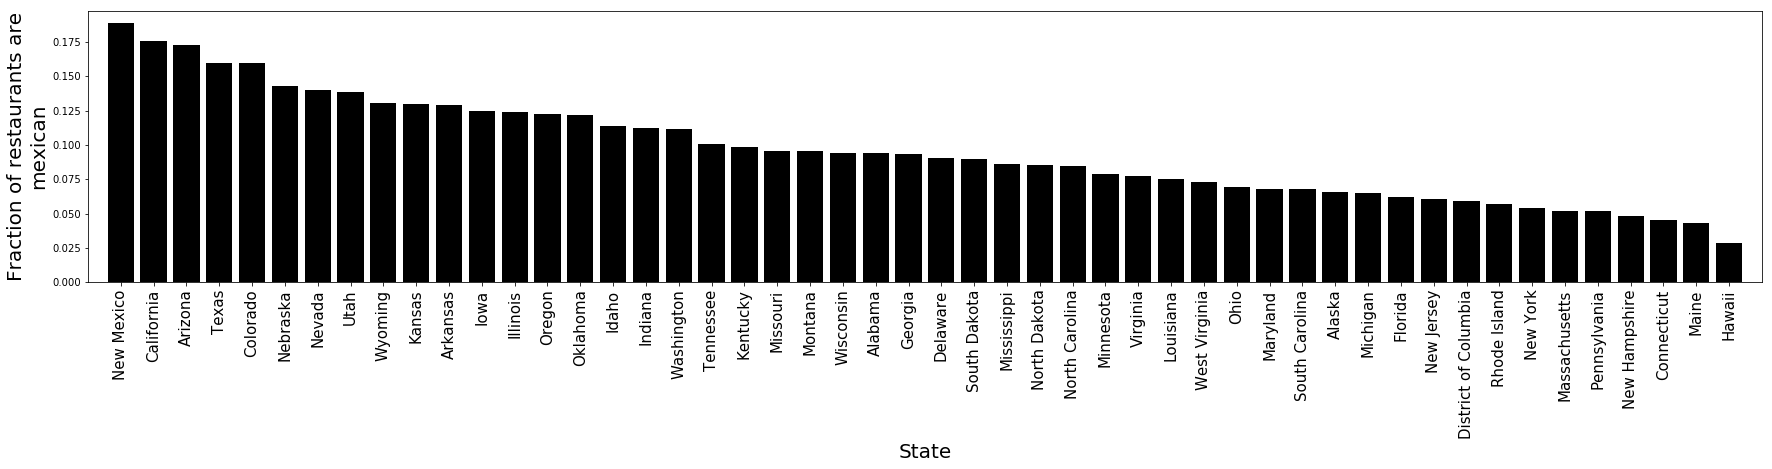

In [54]:
c = 'mexican'
df_state_cuisines.sort_values(c, ascending=False, inplace=True)

plt.figure(figsize=(30,5))
plt.bar(np.arange(len(df_state_cuisines)), df_state_cuisines[c].values, color='k', ecolor='.5')
plt.xticks(np.arange(len(df_state_cuisines)), df_state_cuisines.index)
plt.ylabel('Fraction of restaurants are\n'+c, size=20)
plt.xlabel('State', size=20)
plt.xticks(size=15, rotation='vertical')
plt.xlim((-1, len(df_state_cuisines)))

(-1, 50)

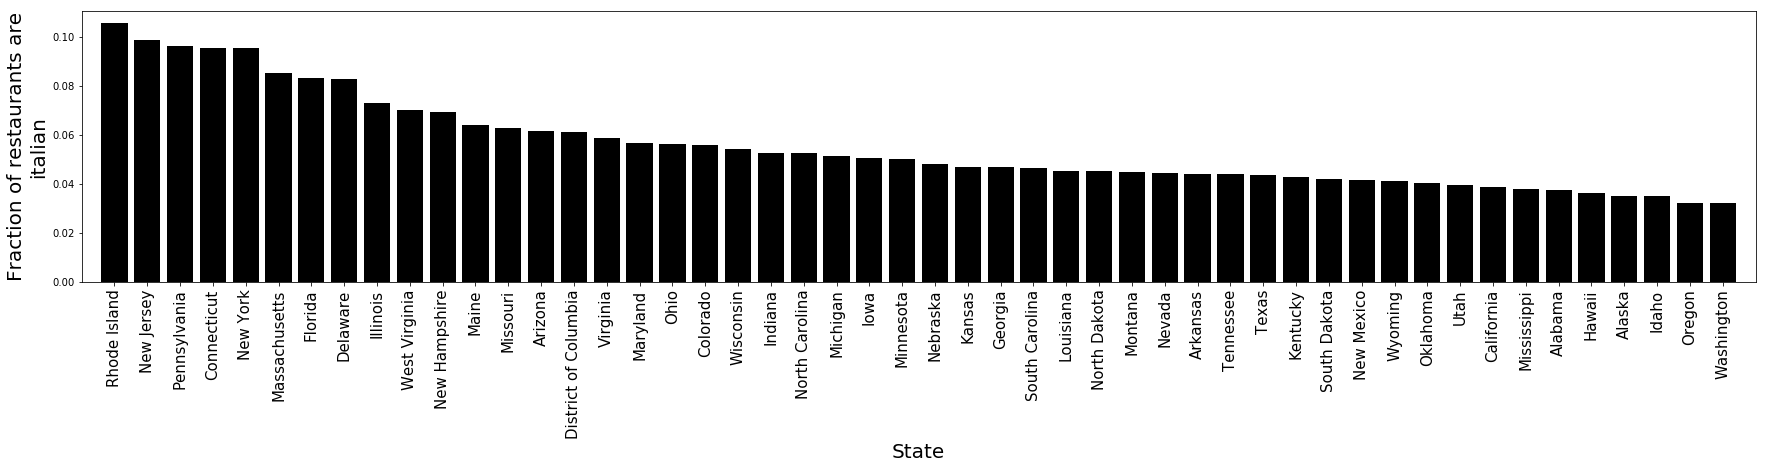

In [55]:
c = 'italian'
df_state_cuisines.sort_values(c, ascending=False, inplace=True)

plt.figure(figsize=(30,5))
plt.bar(np.arange(len(df_state_cuisines)), df_state_cuisines[c].values, color='k', ecolor='.5')
plt.xticks(np.arange(len(df_state_cuisines)), df_state_cuisines.index)
plt.ylabel('Fraction of restaurants are\n'+c, size=20)
plt.xlabel('State', size=20)
plt.xticks(size=15, rotation='vertical')
plt.xlim((-1, len(df_state_cuisines)))